# Notes

I've released a [training kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-training-colab) and an [inference kernel](https://www.kaggle.com/kneroma/clean-fast-simple-bird-identifier-inference). Both of these kernels use a set of pre-computed mels. Which can be found at:

* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part1
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part2
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part3
* https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part4

Unfortunately, these mels are static (7s audio extracts) and you can't get any customization from them. Here, I'm releasing the base kernel that generate them in order to allow everyone to be able to play with the params.

In [1]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import joblib, json

from  sklearn.model_selection  import StratifiedKFold

In [2]:
PART_ID = 0 # The start index in the below list, by changing it you will compute mels on another subset
# PART_INDEXES = [0,15718, 31436, 47154, 62874] # The train_set is splitted into 4 subsets
PART_INDEXES = [0,int(48886/2),48886]

In [3]:
SR = 32_000
DURATION = 5 
SEED = 666

DATA_ROOT = Path("../input/birdclef-2021")
TRAIN_AUDIO_ROOT = Path("../input/birdclef-2021/train_short_audio")
TRAIN_AUDIO_IMAGES_SAVE_ROOT = Path("audio_images") # Where to save the mels images
TRAIN_AUDIO_IMAGES_SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [4]:
def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [5]:
def make_df(n_splits=5, seed=SEED, nrows=None):
    
    df = pd.read_csv(DATA_ROOT/"train_metadata.csv", nrows=nrows)
    
    df = df[df.rating > 3].reset_index(drop=False)

    LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}
    
    df = df.iloc[PART_INDEXES[PART_ID]: PART_INDEXES[PART_ID+1]]

    df["label_id"] = df["primary_label"].map(LABEL_IDS)

    df["filepath"] = [str(TRAIN_AUDIO_ROOT/primary_label/filename) for primary_label,filename in zip(df.primary_label, df.filename) ]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.filepath]

    df = pd.concat([df, pd.DataFrame(pool(tqdm(tasks)))], axis=1, sort=False)
    
    skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = skf.split(np.arange(len(df)), y=df.label_id.values)
    df["fold"] = -1

    for fold, (train_set, val_set) in enumerate(splits):
        
        df.loc[df.index[val_set], "fold"] = fold

    return LABEL_IDS, df

In [6]:
LABEL_IDS, df = make_df(nrows=None)

df.to_csv("rich_train_metadata.csv", index=True)
with open("LABEL_IDS.json", "w") as f:
    json.dump(LABEL_IDS, f)

print(df.shape)
df.head()

  0%|          | 0/24443 [00:00<?, ?it/s]

(24443, 21)


,index,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,...,license,rating,time,url,label_id,filepath,frames,sr,duration,fold
0,3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,...,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,0
1,4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,...,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2
2,5,acafly,[],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2007-11-05,...,Creative Commons Attribution-NonCommercial-Sha...,4.0,07:45,https://www.xeno-canto.org/130056,0,../input/birdclef-2021/train_short_audio/acafl...,1347954,32000,42.123562,4
3,6,acafly,[],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2007-11-12,...,Creative Commons Attribution-NonCommercial-Sha...,4.0,07:50,https://www.xeno-canto.org/130133,0,../input/birdclef-2021/train_short_audio/acafl...,2081890,32000,65.059062,1
4,7,acafly,[],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2007-11-12,...,Creative Commons Attribution-NonCommercial-Sha...,4.0,14:00,https://www.xeno-canto.org/130140,0,../input/birdclef-2021/train_short_audio/acafl...,1008571,32000,31.517844,3


In [7]:
df["fold"].value_counts()

0    4889
1    4889
2    4889
3    4888
4    4888
Name: fold, dtype: int64

In [8]:
df["primary_label"].value_counts()

comrav     500
houwre     500
eursta     500
houspa     500
gbwwre1    500
          ... 
hofwoo1     15
flrtan1     15
grhcha1     13
heptan      10
crfpar       5
Name: primary_label, Length: 191, dtype: int64

<AxesSubplot:>

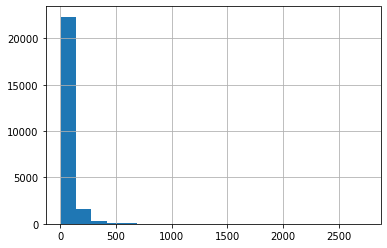

In [9]:
df["duration"].hist(bins=20)

<AxesSubplot:>

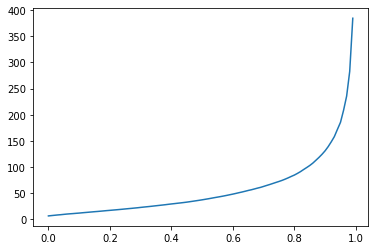

In [10]:
df["duration"].quantile(np.arange(0, 1, 0.01)).plot()

In [11]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [12]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [13]:
audio, orig_sr = sf.read('../input/birdclef-2021/train_short_audio/acafly/XC109605.ogg', dtype="float32")

In [14]:
info = get_audio_info('../input/birdclef-2021/train_short_audio/acafly/XC109605.ogg')

In [15]:
frames = info['frames']
sr = info['sr']
duration = info['duration']

In [16]:
audio_length = int(sr * duration)
audio_length

2037586

In [17]:
audios = [audio[i:i+audio_length] for i in range(0, max(1, len(audio) - audio_length + 1), int(7 * 0.666 * sr))]
# audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
# images = [self.audio_to_image(audio) for audio in audios]

In [18]:
a = []
for i in range(0, len(audio),int(7 * 0.666 * sr)):
    a.append(audio[i:i+audio_length])

In [19]:
for a in audios:
    print(len(a))

2037586


In [20]:
audio, orig_sr = sf.read('../input/birdclef-2021/train_short_audio/acafly/XC109605.ogg', dtype="float32")

In [21]:
Audio(a[-3],rate=sr)

ValueError: Array audio input must be a 1D or 2D array

In [22]:
7 * 0.666 * sr

149184.0

In [23]:
class AudioToImage:
    def __init__(self, sr=SR, n_mels=128, fmin=500, fmax=12500, duration=DURATION, step=None, res_type="kaiser_fast", resample=True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
        
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
#         image = normalize(image, mean=None, std=None)
        return image

    def __call__(self, row, save=True):
#       max_audio_duration = 10*self.duration
#       init_audio_length = max_audio_duration*row.sr
        
#       start = 0 if row.duration <  max_audio_duration else np.random.randint(row.frames - init_audio_length)
    
      audio, orig_sr = sf.read(row.filepath, dtype="float32")

      if self.resample and orig_sr != self.sr:
        audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
        
      audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
      audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
      images = [self.audio_to_image(audio) for audio in audios]
      images = np.stack(images)
        
      if save:
        path = TRAIN_AUDIO_IMAGES_SAVE_ROOT/f"{row.primary_label}/{row.filename}.npy"
        path.parent.mkdir(exist_ok=True, parents=True)
        np.save(str(path), images)
      else:
        print(row.filename, images)
        return  row.filename, images

In [24]:
def get_audios_as_images(df):
    pool = joblib.Parallel(2)
    
    converter = AudioToImage(step=int(DURATION*0.666*SR))
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]
    
    pool(tqdm(tasks))

In [25]:
get_audios_as_images(df)

  0%|          | 0/24443 [00:00<?, ?it/s]

In [26]:
row = df.loc[df.duration.idxmax()]
mels = np.load(str((TRAIN_AUDIO_IMAGES_SAVE_ROOT/row.primary_label/row.filename).as_posix() + ".npy"))
print(mels.shape)

(822, 128, 201)


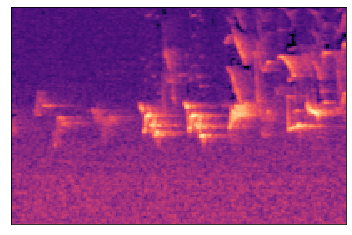

In [27]:
lbd.specshow(mels[0])